In [ ]:
# using Pkg
# Pkg.activate("..")
# Pkg.instantiate()

using Colors
using JLD2
using LaTeXStrings
using LinearAlgebra
using Distributions
using StatsPlots
using RxInfer
using Plots; default(label="", grid=false, markersize=3, margin=15Plots.pt)

## Planned paths

In [ ]:
Δt = 0.2
len_time = 10_000
tsteps = range(0, step=Δt, length=len_time)

In [10]:
trialnum = 13
trialnumpad = lpad(trialnum, 3, '0')
results_EFE = load("results/MARXEFE-botnav-trialnum$trialnumpad.jld2")

T       = results_EFE["len_horizon"] 
N       = results_EFE["len_trial"]
goal    = results_EFE["goal"]
z_0     = results_EFE["z_0"]
z_sim   = results_EFE["z_sim"]
plans_m = results_EFE["plans_m"]
plans_S = results_EFE["plans_S"];

In [33]:
tpoint = 80
clrs = ["orange", "purple", "blue"]
scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
# plot!(z_sim[1,1:tpoint], z_sim[2,1:tpoint], linewidth=3, label="system path", color="blue")
for tt in 1:T
    scatter!([plans_m[1,tt,tpoint]], [plans_m[2,tt,tpoint]], label="y_k+$tt", color=clrs[tt])
    covellipse!(plans_m[:,tt,tpoint], plans_S[:,:,tt,tpoint], n_std=1, alpha=0.1, fillalpha=0.5^tt, color=clrs[tt])
end
plot!(xlims=(-0.5, 0.9), ylims=(-0.2, 1.2), grid=true, size=(400,300), xlabel=L"$z_1$", ylabel=L"$z_2$")

LoadError: LoadError: UndefVarError: `@L_str` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing LaTeXStrings in the current active module Main
in expression starting at c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-acquisition\marxefe-mp\experiments\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:10

In [31]:
savefig("figures/MARXEFE-botnav-plans-tpoint$tpoint.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\MARXEFE-botnav-plans-tpoint80.png"

## Trajectory comparisons

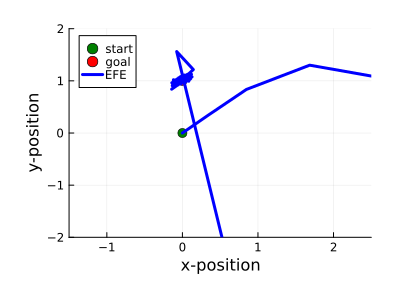

In [15]:
trialnum = 13
trialnumpad = lpad(trialnum, 3, '0')
results_EFE = load("results/MARXEFE-botnav-trialnum$trialnumpad.jld2")
len_trial = results_EFE["len_trial"]
goal      = results_EFE["goal"]
z_EFE     = results_EFE["z_sim"]
z_0       = results_EFE["z_0"]

twindow = 2:10:len_trial
scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
plot!(z_sim[1,twindow], z_sim[2,twindow], linewidth=3, label="EFE", color="blue")
plot!(xlims=(-1.5, 2.5), ylims=(-2, 2), grid=true, size=(400,300), xlabel="x-position", ylabel="y-position")

In [17]:
savefig("figures/MARXEFE-botnav-trajectories-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\MARXEFE-botnav-trajectories-trialnum013.png"

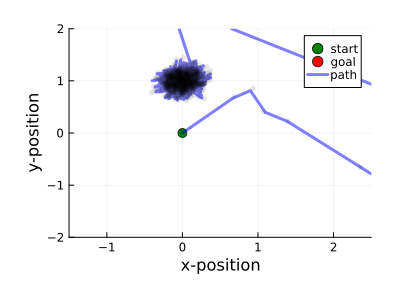

In [19]:
trialnum = 13
trialnumpad = lpad(trialnum, 3, '0')
results_MPC = load("results/MARXMPC-botnav-trialnum$trialnumpad.jld2")
len_trial = results_MPC["len_trial"]
goal      = results_MPC["goal"]
z_MPC     = results_MPC["z_sim"]
y_MPC     = results_MPC["y_sim"]
z_0       = results_MPC["z_0"]

twindow = 2:10:len_trial
scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
plot!(z_MPC[1,twindow], z_MPC[2,twindow], linewidth=3, alpha=0.5, label="path", color="blue")
scatter!(y_MPC[1,twindow], y_MPC[2,twindow], color="black", alpha=0.1)
plot!(xlims=(-1.5, 2.5), ylims=(-2, 2), grid=true, size=(400,300), xlabel="x-position", ylabel="y-position")

In [20]:
savefig("figures/MARXMPC-botnav-trajectories-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\MARXMPC-botnav-trajectories-trialnum013.png"

## Goal alignment

In [1]:
trialnums = [1:4; 6:10; 11;13;14;18;19:24]
ntrials = length(trialnums)

trialnumpad = lpad(trialnums[1], 3, '0')
results_EFE = load("results/MARXEFE-botnav-trialnum$trialnumpad.jld2")
results_MPC = load("results/MARXMPC-botnav-trialnum$trialnumpad.jld2")
len_trial  = results_EFE["len_trial"]
Δt         = results_EFE["Δt"]
tsteps     = range(0, step=Δt, length=len_trial)
goal       = results_EFE["goal"]
m_star     = mean(goal)

F_EFE = zeros(length(trialnums),len_trial)
G_EFE = zeros(length(trialnums),len_trial)
D_EFE = zeros(length(trialnums),len_trial)
U_EFE = zeros(length(trialnums),len_trial)
F_MPC = zeros(length(trialnums),len_trial)
G_MPC = zeros(length(trialnums),len_trial)
D_MPC = zeros(length(trialnums),len_trial)
U_MPC = zeros(length(trialnums),len_trial)

for (i,trialnum) in enumerate(trialnums)
    trialnumpad = lpad(trialnum, 3, '0')
    results_EFE = load("results/MARXEFE-botnav-trialnum$trialnumpad.jld2")
    results_MPC = load("results/MARXMPC-botnav-trialnum$trialnumpad.jld2")
    
    F_EFE[i,:]  = results_EFE["F_sim"]
    G_EFE[i,:]  = results_EFE["G_sim"]
    D_EFE[i,:]  = [norm(results_EFE["y_sim"][:,k] - m_star,2) for k in 1:len_trial]
    U_EFE[i,:]  = [norm(results_EFE["u_sim"][:,k],2) for k in 1:len_trial]

    F_MPC[i,:]  = results_MPC["F_sim"]
    G_MPC[i,:]  = results_MPC["G_sim"]
    D_MPC[i,:]  = [norm(results_MPC["y_sim"][:,k] .- m_star,2) for k in 1:len_trial]
    U_MPC[i,:]  = [norm(results_MPC["u_sim"][:,k],2) for k in 1:len_trial]
end


UndefVarError: UndefVarError: `load` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [2]:
selix = [1:4; 6:10; 11;13;14;18;19]
mF_EFE = median(F_EFE[selix,:],dims=1)
mF_MPC = median(F_MPC[selix,:],dims=1)
sF_EFE = std(F_EFE[selix,:],dims=1) / ntrials
sF_MPC = std(F_MPC[selix,:],dims=1) / ntrials

twindow = 2:len_trial
plot(grid=true, size=(400,300), ylims=(-5,0), xlabel="time (sec)", ylabel="Free energy")
plot!(tsteps[twindow], mF_EFE[twindow], linewidth=3, label="EFE", color="blue")
plot!(tsteps[twindow], mF_MPC[twindow], linewidth=3, label="MPC", color="red")
plot!(xscale=:log10)

UndefVarError: UndefVarError: `F_EFE` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [159]:
savefig("figures/botnav-FE-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\botnav-FE-trialnum020.png"

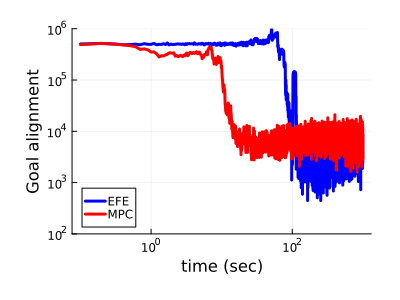

In [160]:
selix = [1:4; 6:10; 11;13;14;18;19]
mG_EFE = median(G_EFE[selix,:],dims=1)
mG_MPC = median(G_MPC[selix,:],dims=1)
sG_EFE = std(G_EFE[selix,:],dims=1) / ntrials
sG_MPC = std(G_MPC[selix,:],dims=1) / ntrials

twindow = 2:len_trial
plot(grid=true, size=(400,300), ylims=(3000,1000_000), xlabel="time (sec)", ylabel="Goal alignment")
plot!(tsteps[twindow], mG_EFE[twindow], linewidth=3, label="EFE", color="blue")
plot!(tsteps[twindow], mG_MPC[twindow], linewidth=3, label="MPC", color="red")
plot!(xscale=:log10, yscale=:log10, ylims=(1e2,1e6), legend=:bottomleft)

In [161]:
savefig("figures/botnav-GA-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\botnav-GA-trialnum020.png"

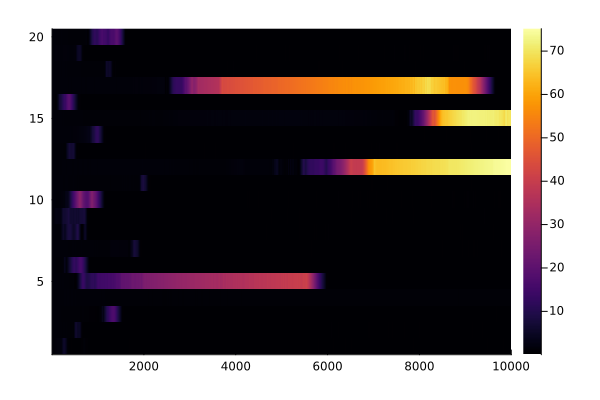

In [162]:
heatmap(D_EFE)

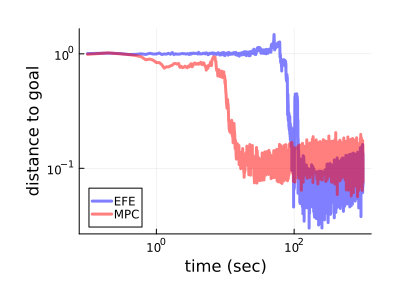

In [163]:
selix = [1:4; 6:10; 11;13;14;18;19]
mD_EFE = median(D_EFE[selix,:],dims=1)
mD_MPC = median(D_MPC[selix,:],dims=1)
sD_EFE = std(D_EFE[selix,:],dims=1) / ntrials
sD_MPC = std(D_MPC[selix,:],dims=1) / ntrials

twindow = 2:len_trial
plot(grid=true, size=(400,300), xlabel="time (sec)", ylabel="distance to goal")
plot!(tsteps[twindow], mD_EFE[twindow], linewidth=3, alpha=0.5, label="EFE", color="blue")
plot!(tsteps[twindow], mD_MPC[twindow], linewidth=3, alpha=0.5, label="MPC", color="red")
plot!(xscale=:log10, yscale=:log10, legend=:bottomleft)

In [164]:
savefig("figures/botnav-N2-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\botnav-N2-trialnum020.png"

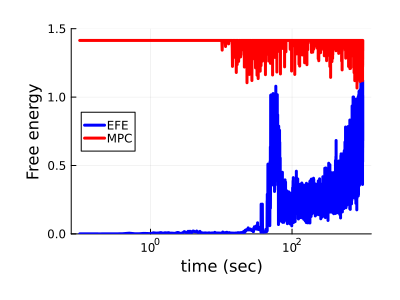

In [165]:
selix = [1:4; 6:10; 11;13;14;18;19]
mU_EFE = median(U_EFE[selix,:],dims=1)
mU_MPC = median(U_MPC[selix,:],dims=1)
sU_EFE = std(U_EFE[selix,:],dims=1) / ntrials
sU_MPC = std(U_MPC[selix,:],dims=1) / ntrials

twindow = 2:len_trial
plot(grid=true, size=(400,300),xlabel="time (sec)", ylabel="Free energy")
plot!(tsteps[twindow], mU_EFE[twindow], linewidth=3, label="EFE", color="blue")
plot!(tsteps[twindow], mU_MPC[twindow], linewidth=3, label="MPC", color="red")
plot!(xscale=:log10, ylims=(0,1.5), legend=:left)

In [166]:
savefig("figures/botnav-U2-trialnum$trialnumpad.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\marxefe-mp\\experiments\\figures\\botnav-U2-trialnum020.png"